<a href="https://colab.research.google.com/github/rkruser/ai4all-umd-2020/blob/master/Image_Recognition_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install flask-ngrok
!git clone https://github.com/rkruser/ai4all-umd-2020.git #https seems to work, but not ssh
%cd ai4all-umd-2020

Cloning into 'ai4all-umd-2020'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 249 (delta 119), reused 116 (delta 35), pack-reused 0
Receiving objects: 100% (249/249), 1.53 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/ai4all-umd-2020/ai4all-umd-2020


In [20]:
%cd ..
!pwd

/content/ai4all-umd-2020
/content/ai4all-umd-2020


In [ ]:
!mkdir data
!mkdir data/leafsnap
!curl -o ./data/leafsnap/leafsnap.tar http://leafsnap.com/static/dataset/leafsnap-dataset.tar
!tar -xvf ./data/leafsnap/leafsnap.tar -C ./data/leafsnap > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  976M  100  976M    0     0  50.2M      0  0:00:19  0:00:19 --:--:-- 70.6M


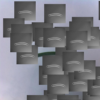

In [26]:
from portia import portiaImP
from PIL import Image
downsize = transforms.Resize(100)
im = Image.open('/content/ai4all-umd-2020/data/leafsnap/dataset/images/field/abies_concolor/12995307070714.jpg')
display(downsize(portiaImP(im)))

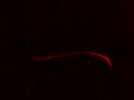

In [ ]:
from emily import emily_function
display(downsize(emily_function(im)))

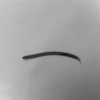

In [ ]:
from Kemka import kemka_function
display(downsize(kemka_function(im)))

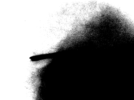

In [ ]:
from Anu import Anu_function
display(downsize(Anu_function(im)))

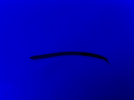

In [ ]:
from Unity import Unity_function
display(downsize(Unity_function(im)))

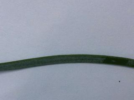

In [ ]:
import shubham
import importlib
shubham=importlib.reload(shubham)
#from shubham import shubham_function
display(downsize(shubham.shubham_function(im)))

**To get your neural network, follow this drive link** to download 
 [your neural network](https://drive.google.com/file/d/1YH70L-pESc8m4N-vgPjVk6YbnUIEUo6k/view?usp=sharing) trained on leafsnap. (The resnet18 model is not necessary; we are loading a separate resnet50 pretrained on [ImageNet](http://www.image-net.org/)). Save the file on your computer, then manually upload it `ai4all-umd-2020/models/your_model` by using the folder interface on the left side of the Colab. (Expand the desired folder, then click on the three dots to the right of its name, and then click "upload").

**Uploading may take a minute. The bottom left corner of Colab should show upload progress.** You may get code errors if you try to run cells before the upload is complete.

**Note that you will have to re-upload if Colab decides to obliterate your file system.** Manual uploads are the simplest solution for right now. The colab will not be wiped clean too often if you are active on it.

**To run the demo,** run the following code cells in order:

In [23]:
# Run resnet50 pretrained on imagenet, your neural network model,
#  and all student image transformations
#  Collect results in a dictionary
import traceback
from flask import Flask, jsonify, request, render_template
from flask_ngrok import run_with_ngrok

#from utils import read_file, transform_image, get_topk, model  #render_prediction

app = Flask(__name__)

import os
import json
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np

import project_network as pnet
import project_train as ptrain
import data_loader

from PIL import Image
import requests
from io import BytesIO
import base64

from data_loader import ClassLoader

def read_file(upload=None, url=None):
    if (upload is not None) and upload.filename:
        in_memory_file = BytesIO()
        upload.save(in_memory_file)
        img = Image.open(in_memory_file)
        return img

    elif url is not None:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img

    else:
        raise NameError('Invalid file/url')

def to_base64(img):
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('ascii')

# Transform input into the form our model expects
def transform_image(pil_image):
    input_transforms = [
        transforms.Resize(255),           # We use multiple TorchVision transforms to ready the image
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],       # Standard normalization for ImageNet model input
            [0.229, 0.224, 0.225]
        )
    ]
    my_transforms = transforms.Compose(input_transforms)
    timg = my_transforms(pil_image)                       # Transform PIL image to appropriately-shaped PyTorch tensor
    timg.unsqueeze_(0)                                    # PyTorch models expect batched input; create a batch of 1
    return timg

leafsnap_transform_image = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor()
])

def get_topk(model, input_tensor, k=5):
    outputs = model(input_tensor)                 # Get likelihoods for all ImageNet classes
    values, indices = torch.topk(outputs, k)              # Extract top k most likely classes
    values = values.data.cpu().numpy()[0]
    indices = indices.data.cpu().numpy()[0]
    return values, indices

resnet50_imagenet_model = models.resnet50(pretrained=True)
resnet50_imagenet_model.eval()
img_class_map = None
mapping_file_path = 'index_to_name.json'                  # Human-readable names for Imagenet classes
if os.path.isfile(mapping_file_path):
    with open (mapping_file_path) as f:
        img_class_map = json.load(f)

device = 'cpu' #We don't need to bother with the GPU when testing the trained model on small sets of images
your_net = pnet.YourNetwork() # A special argument I added to your network --Ryen
net_weights, _ = torch.load('./models/your_model/your_model_49.pth',map_location=device) # The second return value is the optimizer weights, which we don't need now
your_net.load_state_dict(net_weights)
your_net.eval()
leaf_species_name_mapping = ClassLoader()
downsize = transforms.Resize(100)

# Student image transforms
from Anu import Anu_function
from shubham import shubham_function
from emily import emily_function
from portia import portiaImP
from Kemka import kemka_function
from Unity import Unity_function

# Need to return a list of dictionaries with keys 'model', 'label', 'score', 'image'
# Ryen will write this function and get back to you
def collect_outputs(input_pil_image):
  resnet50_im = transform_image(input_pil_image)
  your_net_im = leafsnap_transform_image(input_pil_image).unsqueeze(0)

  r50_vals, r50_inds = get_topk(resnet50_imagenet_model, resnet50_im, 5)
  your_vals, your_inds = get_topk(your_net, your_net_im, 5)

  image_net_results = []
  for value, idx in zip(r50_vals, r50_inds):
    image_net_results.append({
        "model": "ImageNet Resnet50 Pretrained",
        "category": img_class_map.get(str(idx), "Unknown")[1],
        "score": str(value),
        "image": None
    })

  your_net_results = []
  for value, idx in zip(your_vals, your_inds):
    species_name = leaf_species_name_mapping.ind2str(idx)
    species_dir = os.path.join('./data/leafsnap/dataset/images/field/',species_name)
    species_file = os.listdir(species_dir)[0]
    species_file = os.path.join(species_dir, species_file)
    your_net_results.append({
        "model": "Your Network Trained on Leafsnap",
        "category": species_name,
        "score": str(value),
        "image": to_base64(downsize(Image.open(species_file)))
    })

  # In place of "None", write
  #  to_base64( downsize( student_transform( img ) ) )
  #  student_transform must take a PIL image and return a PIL image


  student_image_transforms = [
    {
      "model": "Shubham",
      "category": '-',
      "score": '-',
      "image": to_base64( downsize( shubham_function( input_pil_image ) ) ) 
    },
    {
      "model": "Portia",
      "category": '-',
      "score": '-',
      "image": to_base64( downsize( portiaImP( input_pil_image ) ) )  
    },
    {
      "model": "Kemka",
      "category": '-',
      "score": '-',
      "image": to_base64( downsize( kemka_function( input_pil_image ) ) )     
    },
    {
      "model": "Emily",
      "category": '-',
      "score": '-',
      "image": to_base64( downsize( emily_function( input_pil_image ) ) ) # Fill this in    
    },
    {
      "model": "Unity",
      "category": '-',
      "score": '-',
      "image": to_base64( downsize( Unity_function( input_pil_image ) ) )      
    },
    {
      "model": "Anu",
      "category": '-',
      "score": '-',
      "image": to_base64( downsize( Anu_function( input_pil_image ) ) )      
    },
  ]

  all_results = image_net_results + your_net_results + student_image_transforms

  return all_results


In [24]:
@app.route('/', methods=['GET'])
def root():
    return render_template('index.html')


@app.route('/predict', methods=['GET', 'POST'])
def predict():
    if request.method == 'GET':
        try:
            url = request.args.get('q')
            app.logger.debug('url provided - %s', url)
            input_tensor = transform_image(read_file(url=url))
            values, indices = get_topk(input_tensor)
            results = render_prediction(values, indices)
            return jsonify(results=results)

        except:
            app.logger.debug("Error: %s", traceback.print_exc())
            return jsonify("invalid image url")

    elif request.method == 'POST':
        try:
            file = request.files['file']
            app.logger.debug('file uploaded - %s', file)
            url = request.form.get("url", None)
            app.logger.debug('url provided - %s', url)

            input_pil_image = read_file(upload=file, url=url)
            #values, indices = get_topk(input_tensor)
            results = collect_outputs(input_pil_image)
            return jsonify(results=results)

        except:
            app.logger.debug("Error: %s", traceback.print_exc())
            return jsonify("invalid image")

    else:
        app.logger.debug("Error: %s", traceback.print_exc())
        return jsonify('invalid request')

In [25]:
run_with_ngrok(app)
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://3a09e67ab359.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [31/Jul/2020 17:02:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 17:02:51] "GET /static/main.css HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 17:02:52] "GET /static/main.js HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 17:02:52] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [31/Jul/2020 17:03:01] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 17:03:22] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [31/Jul/2020 17:04:05] "POST /predict HTTP/1.1" 200 -
